# Import necessary libraries

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("COLAB_RELEASE_TAG"):
    print("Running in Google Colab environment.")
    from google.colab import drive
    IN_COLAB = True
else:
    print("Running outside Google Colab environment...")
    IN_COLAB = False

import random
import logging
import keras_cv
import warnings
from time import strftime
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf
from keras import layers as tfkl
from tensorflow import keras as tfk
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Asserting the use of GPU
assert (tf.config.list_physical_devices('GPU')) != [], "No GPU was detected. Aborting."

# Environment Settings
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print(f'Tensorflow Version: {tf.__version__}')


Running outside Google Colab environment...
Tensorflow Version: 2.15.0


# Dataset Processing

### Load training data

In [6]:
# Dataset
if IN_COLAB:
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/Challenge2/

dataset = "Dataset/training_data.npy"
valid_periods_set = "Dataset/valid_periods.npy"
categories_set = "Dataset/categories.npy"
testing_set_size = 0.10

training_data = np.load(f'{dataset}')
valid_periods_x = np.load(f'{valid_periods_set}')
categories = np.load(f'{categories_set}')

### Data inspection

Training Data Shape: (48000, 2776)
Valid Periods Shape: (48000, 2)
Categories Shape: (48000,)


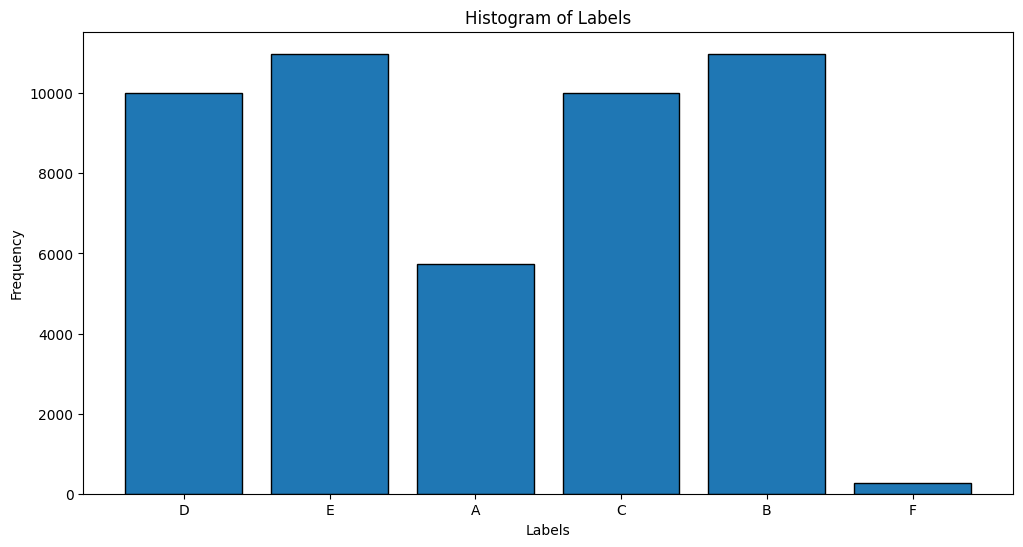

Category A has mean length 278.18034217877096, and min 46, and max 1943, and variance 11942.301799324256
Category B has mean length 165.9428415400018, and min 42, and max 1484, and variance 13487.719678209438
Category C has mean length 208.14625137266646, and min 42, and max 2708, and variance 21398.457097108814
Category D has mean length 216.9909145367412, and min 42, and max 2641, and variance 22250.64638310931
Category E has mean length 163.04601366742597, and min 42, and max 2776, and variance 16380.545582059038
Category F has mean length 194.8303249097473, and min 24, and max 1068, and variance 23449.9242789558


In [12]:
print(f'Training Data Shape: {training_data.shape}')
print(f'Valid Periods Shape: {valid_periods_x.shape}')
print(f'Categories Shape: {categories.shape}')

z=plt.figure(num=1,figsize=(12,6))
plt.hist(categories,bins=range(len(set(categories))+1),edgecolor='black', align='left', rwidth=0.8)
plt.xlabel("Labels")
plt.ylabel("Frequency", )
plt.title("Histogram of Labels")
plt.show()

# Calculate statistics on signal length for each category
def clac_stats(training_data, valid_periods_x):
    # Create a dictionary containing the base signals for each category, without the zero-padding
    valid_signals_dict = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[]}
    for i in range(categories.shape[0]):
        valid_signals_dict[categories[i]].append(training_data[i][valid_periods_x[i][0]:valid_periods_x[i][1]])
    
    stats_dict = {}
    for category in valid_signals_dict:
        stats_dict[category] = {'mean_length':0, 'variance_length':0, 'min_value':0, 'max_value':0}
        lengths = [len(signal) for signal in valid_signals_dict[category]]
        stats_dict[category]['mean_length'] = np.mean(lengths)
        stats_dict[category]['variance_length'] = np.var(lengths)
        stats_dict[category]['min_length'] = np.min(lengths)
        stats_dict[category]['max_length'] = np.max(lengths)
    return stats_dict
    
stats_dict0 = clac_stats(training_data, valid_periods_x)
for category in stats_dict0:
    print(f"Category {category} has "
          f"mean length {stats_dict0[category]['mean_length']}, and "
          f"min {stats_dict0[category]['min_length']}, and "
          f"max {stats_dict0[category]['max_length']}, and "
          f"variance {stats_dict0[category]['variance_length']}")

# Balance the dataset
The distribution of the categories implies the fact that the dataset is imbalanced. To solve this problem, various techniques have been applied. First, the number of samples belonging to classes *A* and *F* has been increased using SMOTE. Then, a subset of samples belonging to classes *B*, *C*, *D*, *E* has been selected randomly, according to a desired sampling strategy, using RandomUnderSampler. The final dataset is still imbalanced, but the disparity between the categories is significantly reduced.

In [13]:
# Calculate the number of samples for each category
label_counts = Counter(categories)

## SMOTE Oversampling
Increase the number of samples belonging to classes *A* and *F*, using SMOTE.

In [14]:
smote_target_ratios = {'A': 1.2, 'B': 1.0, 'C': 1.0, 'D': 1.0, 'E': 1.0, 'F': 5.0}
smote_target_counts = {}
for label, count in label_counts.items():
    smote_target_counts[label] = int(count * smote_target_ratios[label])

smote = SMOTE(sampling_strategy=smote_target_counts, random_state=seed)
smote_training_data, smote_categories = smote.fit_resample(training_data, categories)

label_counts_smote = Counter(smote_categories)

## RandomUnderSampling
Select randomly a subset of samples from categories B, C, D, E, according to the desired sampling strategy. While the dataset remains imbalanced, the disparity between the categories is significantly reduced.

In [15]:
undersampling_target_ratios = {'A':1.0, 'B': 0.8, 'C': 0.8, 'D': 0.8, 'E': 0.8, 'F':1.0}
undersampling_target_counts = {}
for label, count in label_counts_smote.items():
    undersampling_target_counts[label] = int(count * undersampling_target_ratios[label])

undersampler = RandomUnderSampler(sampling_strategy=undersampling_target_counts, random_state=42)
undersampled_training_data, undersampled_categories = undersampler.fit_resample(smote_training_data, smote_categories)

label_counts_undr = Counter(undersampled_categories)

No Sampling:
D: 10016
E: 10975
A: 5728
C: 10017
B: 10987
F: 277

Smote:
D: 10016
E: 10975
A: 6873
C: 10017
B: 10987
F: 1385

Undersampling:
A: 6873
B: 8789
C: 8013
D: 8012
E: 8780
F: 1385


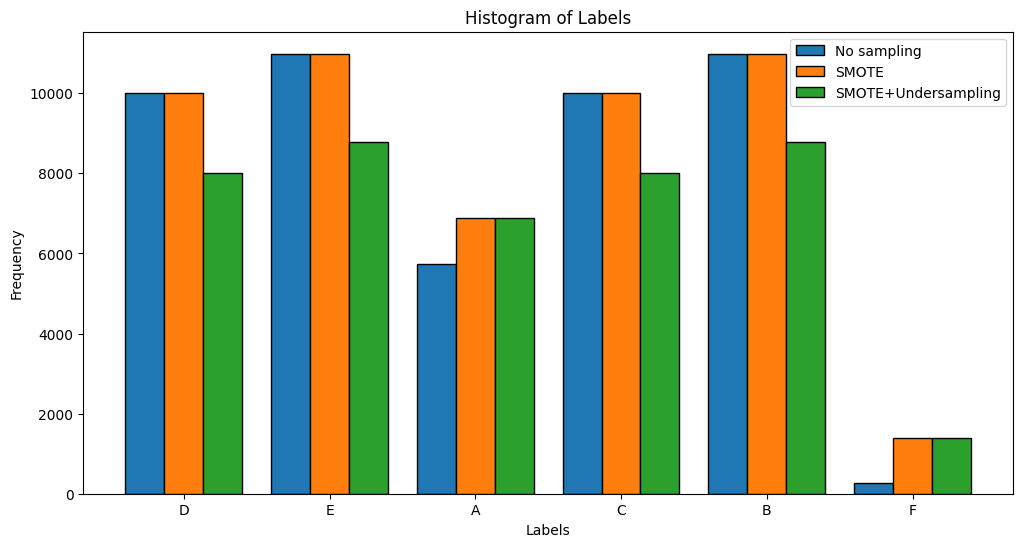

In [16]:
print('No Sampling:')
for label, count in label_counts.items():
    print(f'{label}: {count}')

print('\nSmote:')
for label, count in label_counts_smote.items():
    print(f'{label}: {count}')

print('\nUndersampling:')
for label, count in label_counts_undr.items():
    print(f'{label}: {count}')

z=plt.figure(num=1,figsize=(12,6))
plt.hist([categories,smote_categories,undersampled_categories],bins=range(len(set(categories))+1),edgecolor='black', align='left', rwidth=0.8)
plt.xlabel("Labels")
plt.ylabel("Frequency", )
plt.title("Histogram of Labels")
plt.legend(['No sampling','SMOTE','SMOTE+Undersampling'])
plt.show()

# Data inspection and adjustment

### Update valid periods

In [17]:
training_data = undersampled_training_data
categories = undersampled_categories

# Extract valid periods from the training data, after the resampling process
valid_periods = []
sequence_length = 2776
for i in range(training_data.shape[0]):
    for j in range(training_data.shape[1]):
        if training_data[i][j] != 0:
            # Append the current index and value to valid_periods
            valid_periods.append((j,sequence_length))
            break
valid_periods = np.array(valid_periods)

# Calculate statistics on signal length for each category after resampling
stats_dict1 = clac_stats(training_data, valid_periods)

# Show comparison of the statistics before and after resampling
for category in stats_dict1:
    print(f"Category {category}:\n"
          f"    mean length: {stats_dict0[category]['mean_length']} -> {stats_dict1[category]['mean_length']}\n"
          f"    variance of the length: {stats_dict0[category]['variance_length']} -> {stats_dict1[category]['variance_length']}\n"
          f"    min length: {stats_dict0[category]['min_value']} -> {stats_dict1[category]['min_value']}\n"
          f"    max length: {stats_dict0[category]['max_value']} -> {stats_dict1[category]['max_value']}\n")
          

Category A:
    mean length: 278.18034217877096 -> 278.97613851302197
    variance of the length: 11942.301799324256 -> 12047.50706921521
    min length: 0 -> 0
    max length: 0 -> 0

Category B:
    mean length: 165.9428415400018 -> 165.63204005006259
    variance of the length: 13487.719678209438 -> 13272.20025230651
    min length: 0 -> 0
    max length: 0 -> 0

Category C:
    mean length: 208.14625137266646 -> 206.93248471234244
    variance of the length: 21398.457097108814 -> 21197.46043607006
    min length: 0 -> 0
    max length: 0 -> 0

Category D:
    mean length: 216.9909145367412 -> 215.82588617074387
    variance of the length: 22250.64638310931 -> 21966.825525612607
    min length: 0 -> 0
    max length: 0 -> 0

Category E:
    mean length: 163.04601366742597 -> 163.29589977220957
    variance of the length: 16380.545582059038 -> 16793.959595944394
    min length: 0 -> 0
    max length: 0 -> 0

Category F:
    mean length: 194.8303249097473 -> 215.9754512635379
    vari

### Prepare invalid period for masking

In [20]:
# Set values of invalid periods to -1.0 to be masked in training phase
def mask_invalid_values(data, valid_periods):
    for i in range(data.shape[0]):
        start = valid_periods[i][0]
        end = valid_periods[i][1]
        data[i][:start] = -1.0
        data[i][end:] = -1.0
    return data

training_data = mask_invalid_values(training_data, valid_periods)

### Convert the labels

In [21]:
encoder = LabelEncoder()
labels = encoder.fit_transform(categories)
labels = to_categorical(labels)
print(labels.shape)

(41852, 6)


### Split the dataset

In [22]:
X_train_val, X_tests, y_train_val_classification, y_test_classification = train_test_split(training_data, categories, random_state=seed, test_size=0.05, stratify=categories)
X_trains, X_vals, y_train_classification, y_val_classification = train_test_split(X_train_val, y_train_val_classification, random_state=seed, test_size=0.15, stratify=y_train_val_classification)

In [23]:
test_length = 18

In [24]:
def organize_data(X_):
  X_ = np.expand_dims(X_, axis=-1) # monovariate -> expand axis=-1 with 1

  # X
  X = X_[:,:-test_length] # exclude the last 18 samples
  X = X[:, -200:] # fixed dimension, consider only last 200 samples

  # y
  y_forecasting = X_[:,-test_length:] # last 18 samples of each serie

  return X, y_forecasting

In [25]:
X_train, y_train_forecasting = organize_data(X_trains)
X_val, y_val_forecasting = organize_data(X_vals)
X_test, y_test_forecasting = organize_data(X_tests)

In [26]:
# X_
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33795, 200, 1)
(5964, 200, 1)
(2093, 200, 1)


In [27]:
# Y_
print(y_train_forecasting.shape)
print(y_val_forecasting.shape)
print(y_test_forecasting.shape)

(33795, 18, 1)
(5964, 18, 1)
(2093, 18, 1)


# Build and fit the model

In [28]:
input_shape = X_train.shape[1:]
print(input_shape)

output_shape = y_train_forecasting.shape[1:]
print(output_shape)

batch_size = 64
epochs = 150

(200, 1)
(18, 1)


In [29]:
def build_BiLSTM_classifier(input_shape, output_shape):
    input_layer = tfk.layers.Input(shape=input_shape, name='Input')

    # Mask, consider only samples in valid_periods
    mask = tf.keras.layers.Masking(mask_value=-1.0, input_shape=input_shape)(input_layer)

    # Convolutional
    conv_layer = tfkl.Conv1D(200,6,padding="same",strides=1,name="Conv")(mask)

    # Pooling
    pooling = tfkl.MaxPooling1D(3,padding="same")(conv_layer)

    # BiLSTM
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(pooling)
    bilstm1 = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(bilstm)

    # Dropout
    dropout = tfk.layers.Dropout(0.5)(bilstm1)

    # Flattening
    flattening = tfkl.Flatten()(dropout)

    # Prediction
    output_layer = tfkl.Dense(output_shape[0], activation='linear', name='output_layer')(flattening)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    # Return the model
    return model

In [30]:
# build the model
model = build_BiLSTM_classifier(input_shape, output_shape)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 1)]          0         
                                                                 
 masking (Masking)           (None, 200, 1)            0         
                                                                 
 Conv (Conv1D)               (None, 200, 200)          1400      
                                                                 
 max_pooling1d (MaxPooling1  (None, 67, 200)           0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 67, 512)           935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 67, 512)           157491

In [31]:
# block schema
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = {'output_layer': y_train_forecasting},
    batch_size = batch_size,
    epochs = epochs,
    validation_data= ( X_val,  y_val_forecasting),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ]
).history

Epoch 1/150
529/529 [==============================] - 33s 40ms/step - loss: 0.0340 - val_loss: 0.0216
Epoch 2/150
529/529 [==============================] - 20s 38ms/step - loss: 0.0218 - val_loss: 0.0201
Epoch 3/150
529/529 [==============================] - 19s 37ms/step - loss: 0.0202 - val_loss: 0.0193
Epoch 4/150
529/529 [==============================] - 19s 36ms/step - loss: 0.0195 - val_loss: 0.0238
Epoch 5/150
529/529 [==============================] - 19s 37ms/step - loss: 0.0191 - val_loss: 0.0220
Epoch 6/150
529/529 [==============================] - 19s 37ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 7/150
529/529 [==============================] - 22s 41ms/step - loss: 0.0182 - val_loss: 0.0216
Epoch 8/150
529/529 [==============================] - 20s 37ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 9/150
529/529 [==============================] - 19s 37ms/step - loss: 0.0177 - val_loss: 0.0180
Epoch 10/150
529/529 [==============================] - 19s 37ms/step - l

# Prediction

In [ ]:
# predictions
forecasting_predictions = model.predict(X_test, verbose=0)

In [ ]:
# Mean Squared Error
mean_squared_error = tfk.metrics.mean_squared_error(y_test_forecasting.flatten(), forecasting_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

Mean Squared Error: 0.011693797074258327


In [ ]:
# Mean Absolute Error
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_forecasting.flatten(), forecasting_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Mean Absolute Error: 0.07036209851503372
